**About** : This notebook is used to do inference on test data

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

## Initialization

In [3]:
import gc
import os
import ast
import sys
import cv2
import glob
import json
import warnings
import pycocotools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

warnings.simplefilter("ignore", UserWarning)

In [4]:
from params import *

from data.preparation import sub_to_mmdet, prepare_data, get_splits
from data.transforms import define_pipelines
from data.dataset import SartoriusInferenceDataset

from utils.logger import Config
from utils.rle import rle_decode
from utils.plots import plot_sample

from inference.test import inference

In [5]:
IS_PL = True
FOLD = 0 if IS_PL else "*"

## Config

In [6]:
EXP_FOLDERS = [  # ENS_8
    LOG_PATH + "2021-12-11/2/",  # 1. Cascade b5 - 0.3127
    LOG_PATH + "2021-12-11/4/",  # 2. Cascade rx101 - 0.3141
    LOG_PATH + "2021-12-12/0/",  # 3. Cascade r50 - 0.3125
    LOG_PATH + "seb/mrcnn_resnext101_lossdecay/", # 11. mrcnn r101 0.3131
    LOG_PATH + "seb/mrcnn_r50_lossdecay/", # 12. mrcnn r50 0.3125
    LOG_PATH + "2021-12-15/0/",  # 14. Cascade b6 - 0.3121
]

In [7]:
THRESHOLDS_MASK = 0.45
THRESHOLDS_NMS = [0.1, 0.1, 0.15]
THRESHOLDS_CONF = [0.3, 0.4, 0.65]

In [8]:
ENSEMBLE_CONFIG = {
    "use_tta": True,
    "num_classes": 3,

    "rpn_nms_pre": [3000, 2000, 1000],
    "rpn_iou_threshold": [0.75, 0.75, 0.6],
    "rpn_score_threshold": [0.95, 0.9, 0.95],
    "rpn_max_per_img": [None, None, None],  # [1500, 1000, 500],

    "bbox_nms": True,
    "rcnn_iou_threshold": [0.75, 0.9, 0.6],
    "rcnn_score_threshold": [0.2, 0.3, 0.5],
}

In [9]:
if IS_PL:
    df = pd.DataFrame({'id': os.listdir(DATA_PATH + "train_semi_supervised/")})
    df['predicted'] = ""
    df['img_path'] = DATA_PATH + "train_semi_supervised/" + df['id']
#     df = df.head(5)

    df['plate'] = df['id'].apply(lambda x: x.split('_')[0])
    df['well'] = df['id'].apply(lambda x: x.split('_')[1][:-2])
    df['plate_well'] = df['plate'] + "_" + df['well']

else:
    df = pd.read_csv(DATA_PATH + "sample_submission.csv")
    df['img_path'] = DATA_PATH + "test/" + df['id'] + ".png"

In [10]:
configs, weights = [], []

for exp_folder in EXP_FOLDERS:
    config = Config(json.load(open(exp_folder + "config.json", 'r')))
    config.model_config = exp_folder + config.model_config.split('/')[-1]
    config.data_config = exp_folder + config.data_config.split('/')[-1]
    configs.append(config)

    weights.append(sorted(glob.glob(exp_folder + f"*_{FOLD}.pt")))

In [11]:
df_train = prepare_data(fix=False, remove_anomalies=config.remove_anomalies)
splits = get_splits(df_train, config)

## Single fold

### Inference

In [12]:
%%time
rles = inference(
    df.head(10),
    configs,
    weights,
    ENSEMBLE_CONFIG,
    THRESHOLDS_MASK,
    THRESHOLDS_NMS,
    THRESHOLDS_CONF,
    corrupt=not IS_PL,
    remove_overlap=not IS_PL,
)


CPU times: user 52 s, sys: 9.06 s, total: 1min 1s
Wall time: 56.5 s


### Viz

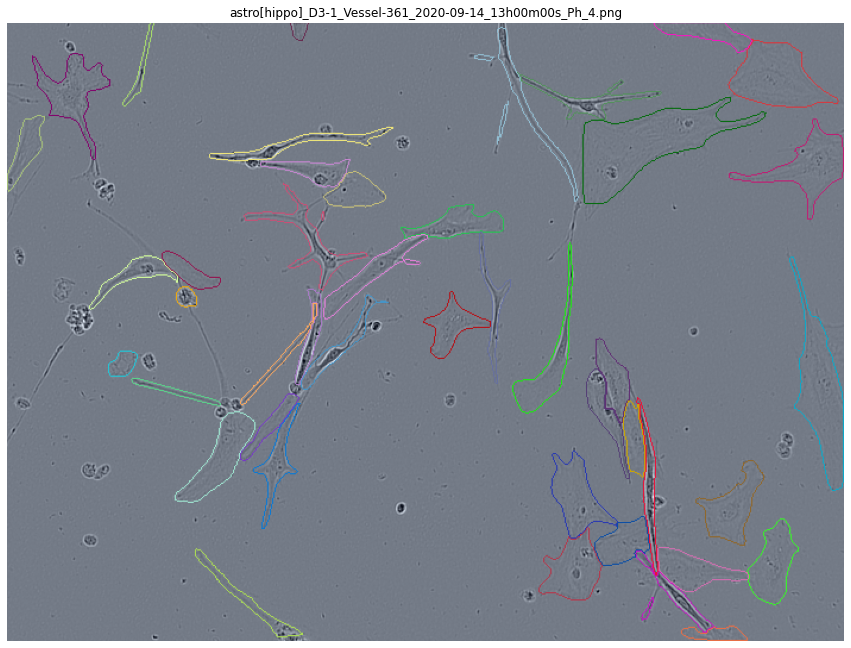

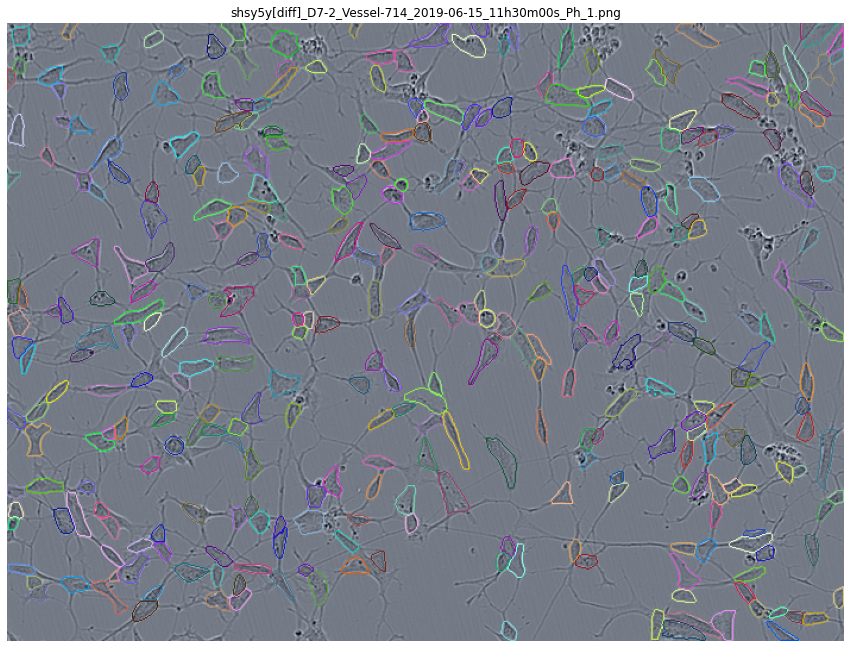

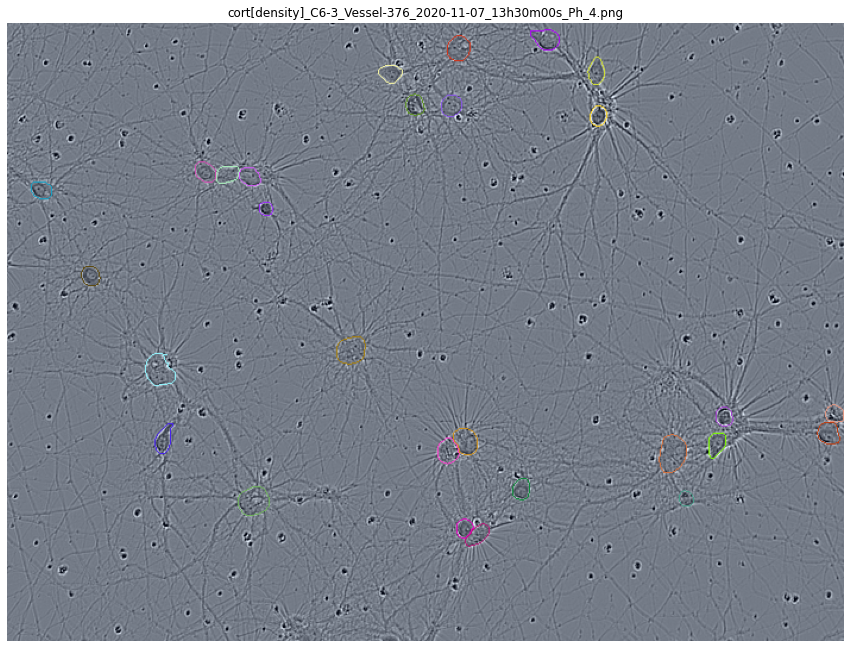

In [13]:
submission = []
pipelines = define_pipelines(config.data_config)
dataset = SartoriusInferenceDataset(df, transforms=pipelines['test_viz'])

for idx, (rle, img_id) in enumerate(zip(rles, df['id'].values)):
    if idx < 3:
        img = dataset[idx]['img'][0].numpy().transpose(1, 2, 0)
        img = (img - img.min()) / (img.max() - img.min())
        img = img[:ORIG_SIZE[0], :ORIG_SIZE[1]]

        masks = np.array([rle_decode(enc, ORIG_SIZE) for enc in rle])
        
        plt.figure(figsize=(15, 15))
        plot_sample(img, masks.astype(int))
        plt.axis(False)
        plt.title(img_id)
        plt.show()        

    for enc in rle:
        submission.append((img_id, enc))

    if not len(rle):  # Empty
        submission.append((image_id, ""))

df_sub = pd.DataFrame(submission, columns=['id', 'predicted'])

### Generate PLs

In [14]:
df_g = df_sub.groupby('id').agg(list).reset_index()
masks, meta = sub_to_mmdet(df_g, 0)

# plt.figure(figsize=(15, 10))
# plot_sample(255 * np.ones(ORIG_SIZE, dtype=np.uint8), masks.astype(int), meta['ann']['bboxes'], width=1)
# plt.axis(False)
# plt.show()

In [15]:
# metas = [sub_to_mmdet(df_g, i)[1] for i in range(len(df_g))]
# meta_df = pd.DataFrame.from_dict(metas)
# meta_df.to_csv(OUT_PATH + f"pl_ens15_{FOLD}.csv", index=False)
# print(f' -> Saved pls to "{OUT_PATH}pl_ens15_{FOLD}.csv"')

## All folds

In [ ]:
assert IS_PL

for FOLD in range(0, 5):
    print('\t\t' + '#' * 10)
    print(f'\t\t# Fold {FOLD} #')
    print('\t\t' + '#' * 10 + '\n')

    configs, weights = [], []
    for exp_folder in EXP_FOLDERS:
        config = Config(json.load(open(exp_folder + "config.json", 'r')))
        config.model_config = exp_folder + config.model_config.split('/')[-1]
        config.data_config = exp_folder + config.data_config.split('/')[-1]
        configs.append(config)

        weights.append(sorted(glob.glob(exp_folder + f"*_{FOLD}.pt")))
        
    train_idx, val_idx = splits[FOLD]
    plate_well_val = df_train.iloc[val_idx]['plate_well'].unique()
    
    df_inf = df[~df['plate_well'].isin(plate_well_val)].reset_index(drop=True)
    print(f' -> Making inference on {len(df_inf)} images using {len(weights)} models\n')

    rles = inference(
        df_inf,
        configs,
        weights,
        ENSEMBLE_CONFIG,
        THRESHOLDS_MASK,
        THRESHOLDS_NMS,
        THRESHOLDS_CONF,
        corrupt=not IS_PL,
        remove_overlap=not IS_PL,
    )

    submission = []
    for idx, (rle, img_id) in enumerate(zip(rles, df_inf['id'].values)):
        for enc in rle:
            submission.append((img_id, enc))
        if not len(rle):
            submission.append((image_id, ""))
    df_sub = pd.DataFrame(submission, columns=['id', 'predicted'])
    df_g = df_sub.groupby('id').agg(list).reset_index()

    metas = [sub_to_mmdet(df_g, i)[1] for i in range(len(df_g))]
    meta_df = pd.DataFrame.from_dict(metas)
    meta_df.to_csv(OUT_PATH + f"pl_ensnew_{FOLD}.csv", index=False)
    print(f' -> Saved pls to "{OUT_PATH}pl_ens15_{FOLD}.csv"\n\n')

		##########
		# Fold 0 #
		##########

 -> Making inference on 1582 images using 6 models

